# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

<font color=darkred>
Per the published by the researchers, the original data set represents, 17 campaign types that occurred between May 2008 and Nov 2010 and corresponds to 79354 contacts. The data provided to use for this analysis contains 41188 contacts or records
</font>

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import time

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder,  LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE                # For oversampling minority class 
from imblearn.under_sampling import RandomUnderSampler  # For undersampling majority class
from imblearn.metrics import specificity_score

from sklearn.metrics import RocCurveDisplay, roc_curve, auc

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# read the bank data
bankdata = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
bankdata.sample(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
13912,31,admin.,single,university.degree,no,no,no,telephone,jul,fri,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
38704,32,admin.,married,university.degree,no,no,no,cellular,nov,mon,...,2,999,1,failure,-3.4,92.649,-30.1,0.715,5017.5,no
5210,32,services,single,professional.course,no,yes,yes,telephone,may,fri,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
bankdata.shape

(41188, 21)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
bankdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
bankdata.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
# Check for duplicates
duplicate_rows = bankdata.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_rows}')

# Remove duplicate rows
bankdata = bankdata.drop_duplicates()
print(f'Dataset shape after removing duplicates: {bankdata.shape}')

# Check for null values
null_values = bankdata.isnull().sum()
print(f'Null values in each column:\n{null_values}')

# Since duration is alreaady deamed to be a predictor of success, and can't predict how long a customer service agent may talk to the client
# how many calls would require to get the answer about deposit, we will drop these feature from the analysis.
bankdata.drop(['campaign','duration', 'pdays'], axis=1, inplace=True)

Number of duplicate rows: 12
Dataset shape after removing duplicates: (41176, 21)
Null values in each column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [8]:
# Find outliers in the data using the IQR method
numerical_columns = bankdata.select_dtypes(include=['int64', 'float64']).columns

df_numerical = bankdata[numerical_columns]

Q1 = df_numerical.quantile(0.25)
Q3 = df_numerical.quantile(0.75)
IQR = Q3 - Q1

total_outliers = ((df_numerical < (Q1 - 1.5 * IQR)) | (df_numerical > (Q3 + 1.5 * IQR))).sum()
print(f'Outliers in each column:\n{total_outliers}')

outliers = ((df_numerical < (Q1 - 1.5 * IQR)) | (df_numerical > (Q3 + 1.5 * IQR)))


# Remove outliers from the dataset
print(f'Original dataset shape: {bankdata.shape}')
print(f'Removing outliers will change the dataset shape to : {bankdata[~outliers.any(axis=1)].shape}')


Outliers in each column:
age                468
previous          5625
emp.var.rate         0
cons.price.idx       0
cons.conf.idx      446
euribor3m            0
nr.employed          0
dtype: int64
Original dataset shape: (41176, 18)
Removing outliers will change the dataset shape to : (35048, 18)


<font color=darkred>
Even though there are outliers in a few columns such as duration, campaign, pdays, previous, i have chosen not to temove these records, as they will significantly reduce the data set. 
Instead we will use the StandardScaler to scale these values


In [9]:
# review the values in the categorical columns 

for column in bankdata.select_dtypes(include='object').columns:
    print(f"Unique values in {column}: {bankdata[column].unique()}")

Unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Unique values in marital: ['married' 'single' 'divorced' 'unknown']
Unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Unique values in default: ['no' 'unknown' 'yes']
Unique values in housing: ['no' 'yes' 'unknown']
Unique values in loan: ['no' 'yes' 'unknown']
Unique values in contact: ['telephone' 'cellular']
Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Unique values in day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']
Unique values in poutcome: ['nonexistent' 'failure' 'success']
Unique values in y: ['no' 'yes']


<font color=darkred>Apart from education column, it does not appear the values in categorical columns needs to be co-erced into some other values. For the education column - there does appear to be an order in the level education starting with illeterate, 4yr, 6y, 9y, high school, professional course, degree, unknown. We could consider creating an ordinal transformer for this column in our pipeline, however i am not sure if this order makes a difference in determining the success of the campaign</font>

## EDA

<Axes: xlabel='y', ylabel='Count'>

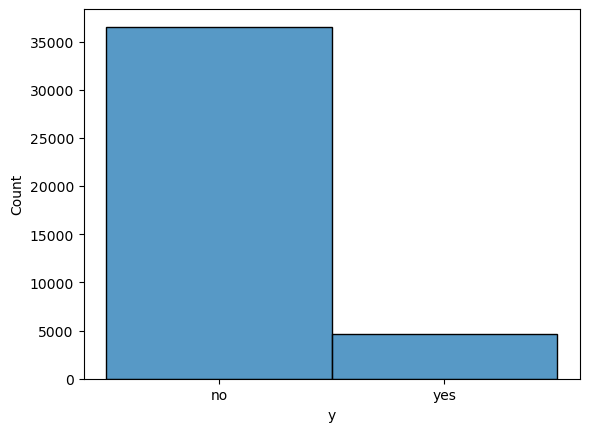

In [10]:
# Examine the distribution of the target variable

sns.histplot(bankdata['y'])

<font color=darkred>This is a very imbalanced data set with ~90% unsuccessful campaigns i.e. clients did not subscribe to term deposits. Consider leveraging SMOTE and other class balancing techniques</font>

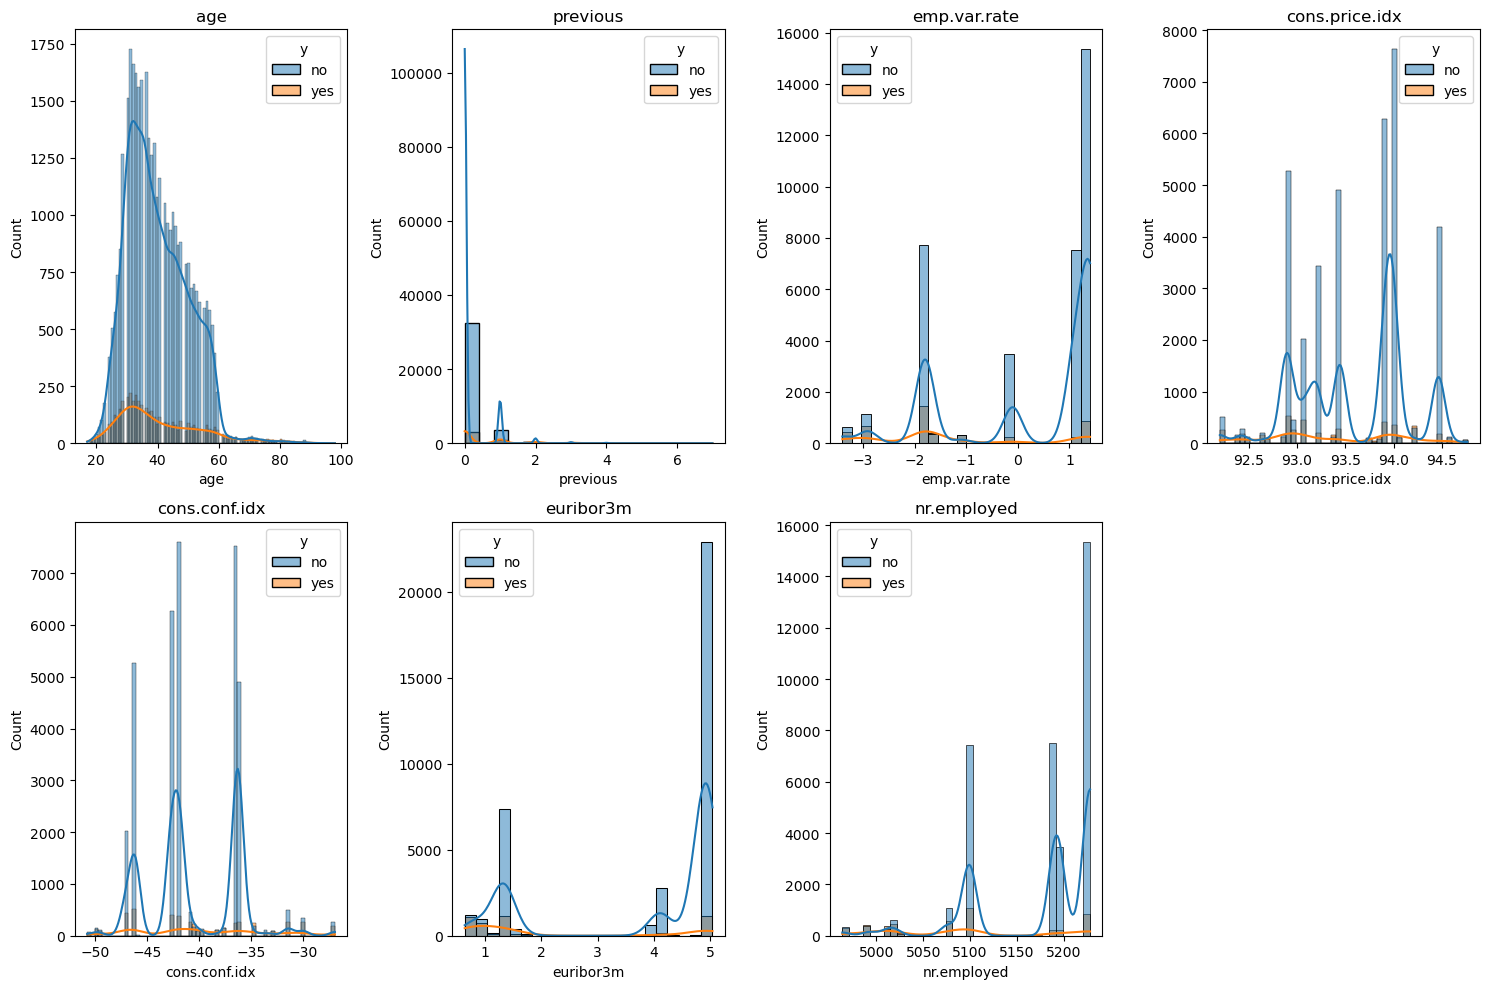

In [11]:
# Plot the distribution of numerical columns

num_cols = 4        # Define the number of rows and columns for the grid
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(x=bankdata[column], ax=axes[i], hue=bankdata['y'], kde=True)
    axes[i].set_title(f'{column}')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<font color=darkred>**Distributions of Numerical Columns**

- **Age**: Age appears to show higher acceptance rates with customers who are older
- **pdays**: column does not have much variability, consider removing it
- **eurobir3m**: eurobir (Euro Interbank Offered Rate: based on the average interest rates at which a large panel of European banks borrow funds from one another). It seems that if Eurobir rate is lower, there is a higher chance of accepttance of a term deposit


In [12]:
#sns.histplot(data = bankdata['euribor3m'], x=)

# Calculate the mean of 'y_numeric' grouped by 'euribor3m'
euribor3m_mean = bankdata.groupby('y')['euribor3m'].mean()
euribor3m_mean


y
no     3.811482
yes    2.123362
Name: euribor3m, dtype: float64

<font color=darkred>Success with customers purchasing bank deposits seems to be higher when the Euribor rates are lower. This is counter intuititve, since a higher Euribor rate would imply higher term deposit rate and hence higher bank deposit acceptance rate. This requires further discussion with a SME to understand these rates and its impact.

<Axes: xlabel='y', ylabel='age'>

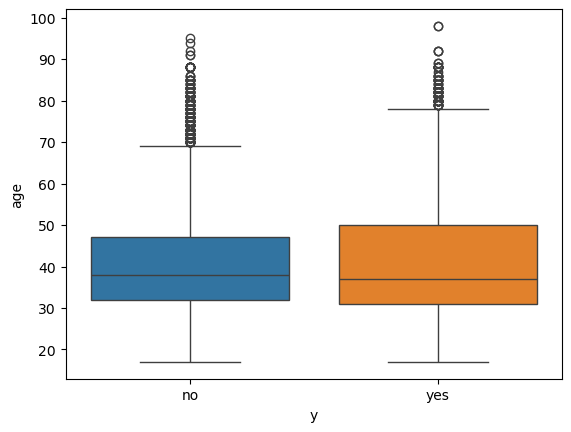

In [13]:
# compare age column with the target variable

sns.boxplot(y=bankdata['age'], x=bankdata['y'], hue=bankdata['y'])

In [14]:
bankdata['y_numeric'] = bankdata['y'].apply(lambda x: 1 if x == 'yes' else 0)

before_60 = round((bankdata[bankdata.age < 60].y_numeric.sum()/sum(bankdata.age < 60))*100, 2)
after_60 = round((bankdata[bankdata.age > 60].y_numeric.sum()/sum(bankdata.age > 60))*100, 2)

print('Before 60: {}% subscribed\nAfter 60: {}% subscribed'.format(before_60, after_60))

Before 60: 10.42% subscribed
After 60: 45.54% subscribed


<font color=darkred>
Success with customers > 60 yrs of age is 45%, which is 35% higher than custoemrs who are less than 60 yrs of age
</font>

<Axes: xlabel='y', ylabel='nr.employed'>

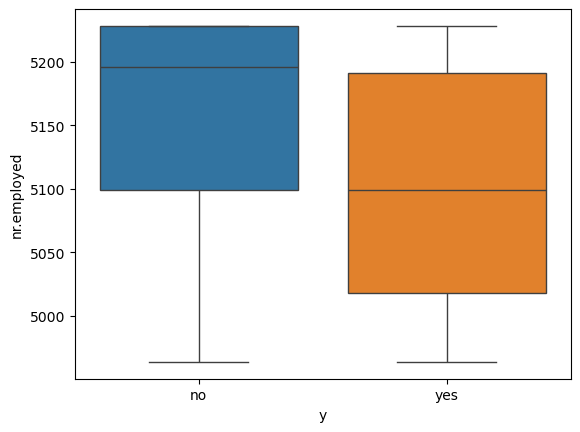

In [15]:
# compare nr.employed in the bank column with the target variable

sns.boxplot(y=bankdata['nr.employed'], x=bankdata['y'], hue=bankdata['y'])

<font color=darkred>
This was added to the EDA after doing the model evaluation. DT model indicates this feature as being the most important.
I do not fully understand the meaning of this column. Maybe it is the number of employees in the bank, if so, i am not sure how it affects the outcome of the campaigns. This requires further discussion with a SME. 
</font>


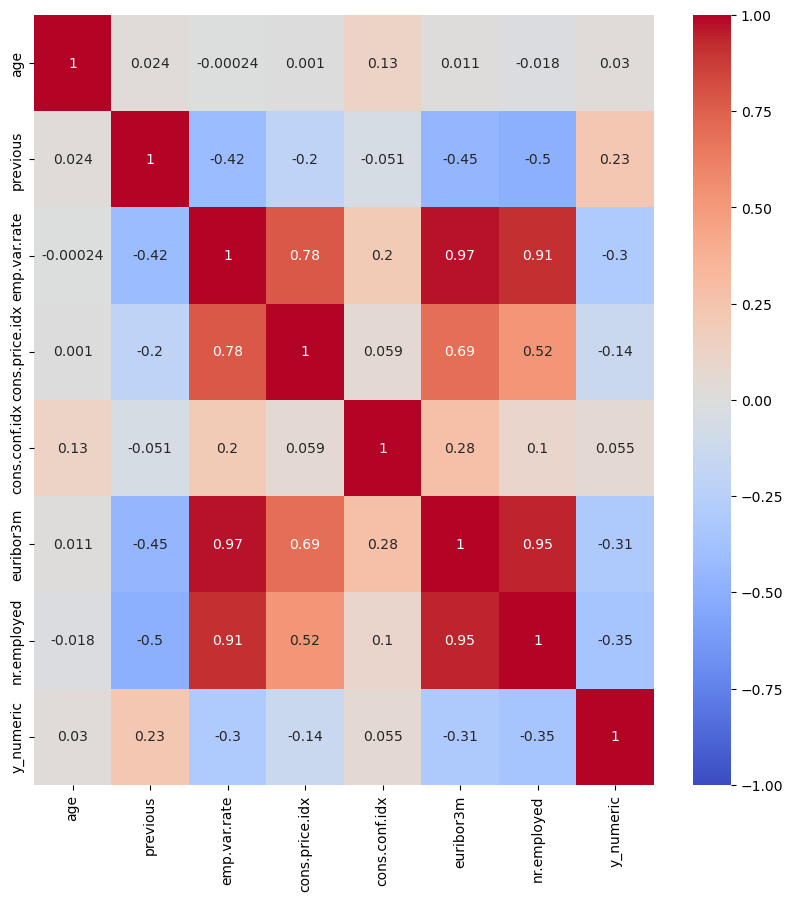

In [16]:
# Review the correlation between numerical columns

plt.figure(figsize=(10, 10))
ax = sns.heatmap(bankdata.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

<font color=darkred>
The societal numerical features - emp.var.rate, consumer price index, consumer confidence index are highly correlated to each other. On the flip side, as expected they have no correlation to the client information (age) or campaign info(duration, and campaign). From the correlation heatmap the euribor3m has a negative correlation to success, but it is not that high

In [17]:

# # Define the categorical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

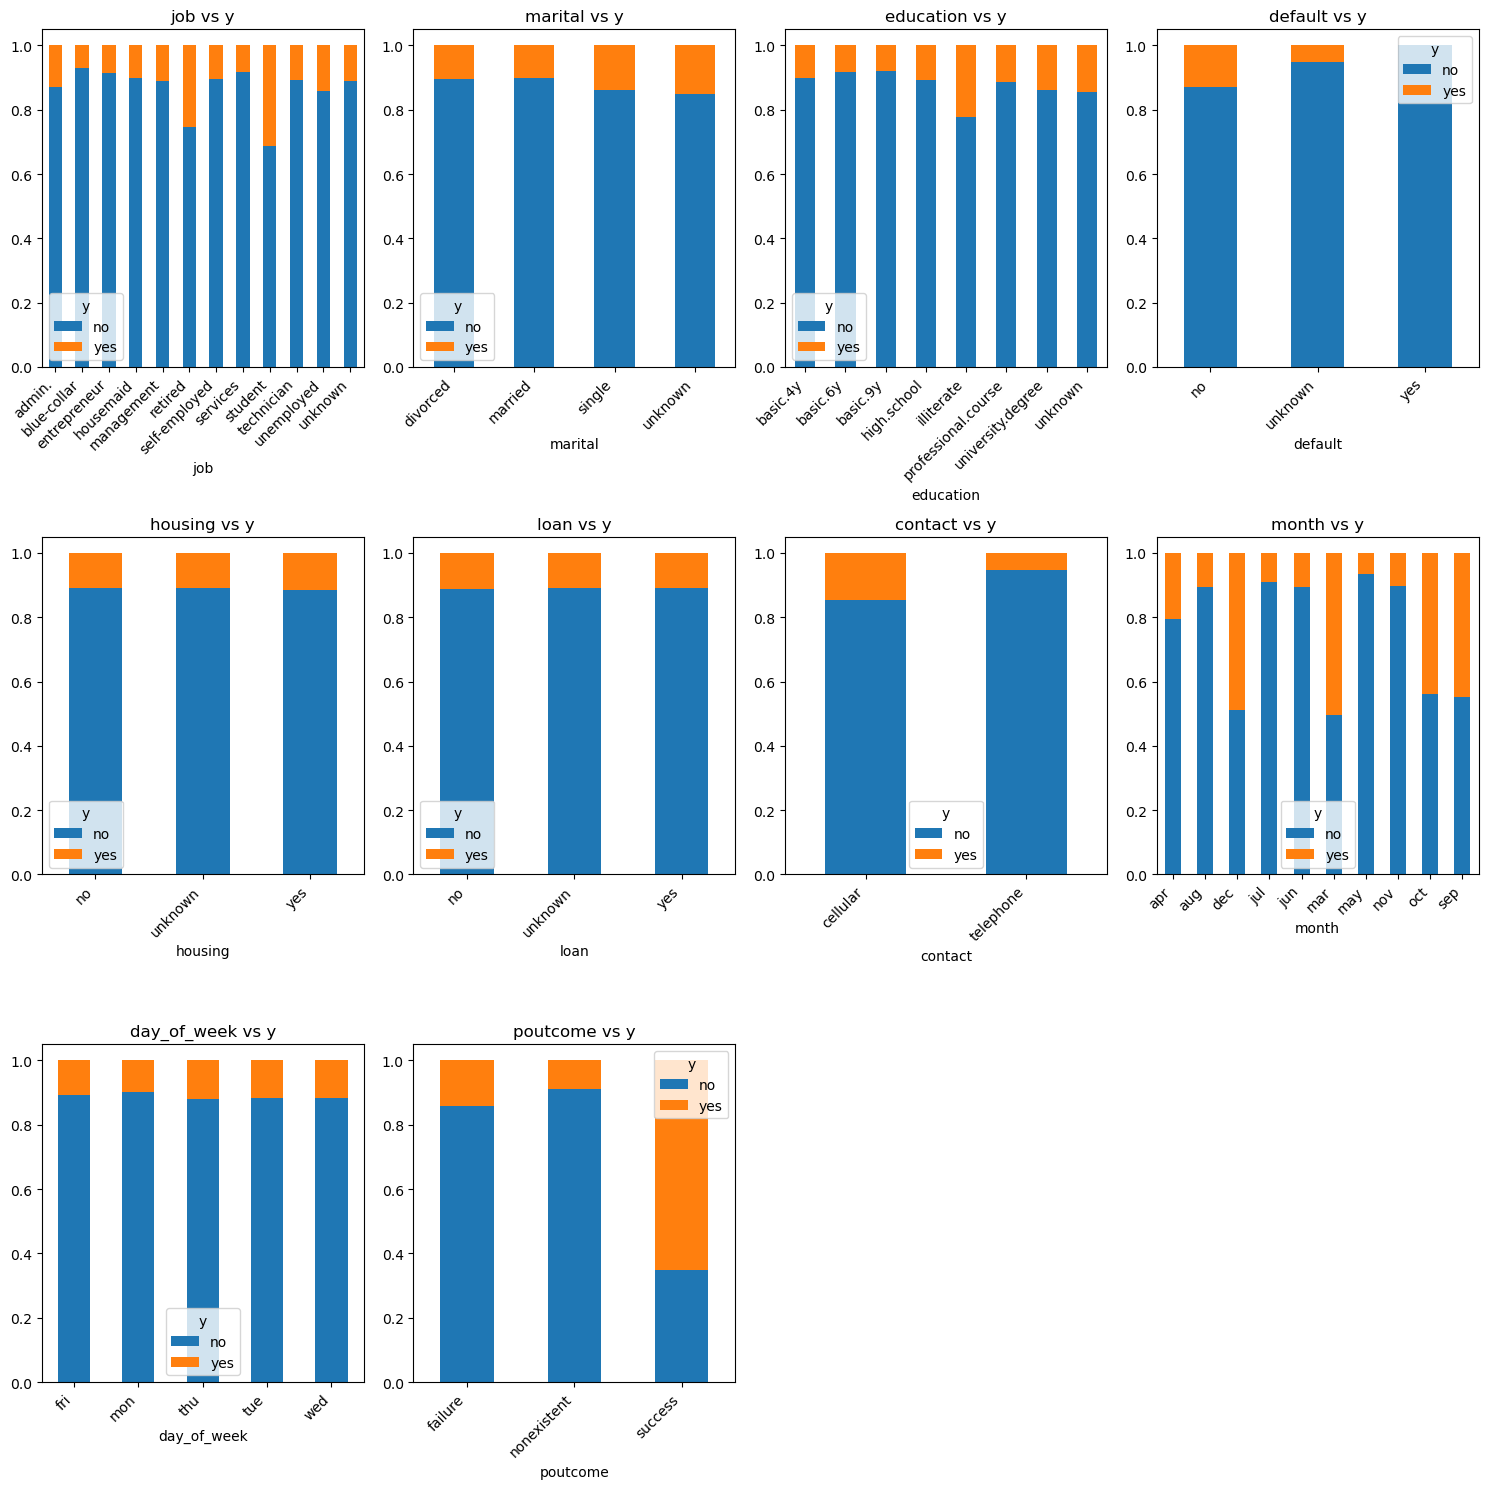

In [18]:
# Examine the categorical variables with y values normalized

# Define the number of rows and columns for the grid
num_cols = 4
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iterationa
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    # Calculate the ratio
    ratio = bankdata.groupby([column, 'y']).size().unstack().apply(lambda x: x / x.sum(), axis=1)
    ratio.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{column} vs y')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<font color=darkred>

- Campaign calls appear to have higher success with customers when 
    - calls are made in dec, jun, sept, oct months
    - calls are made on mobiles
    - calls are made to students or retired
    - calls are made to customers with prior success

Returned clients who has subscribed to the new term deposit: 65%


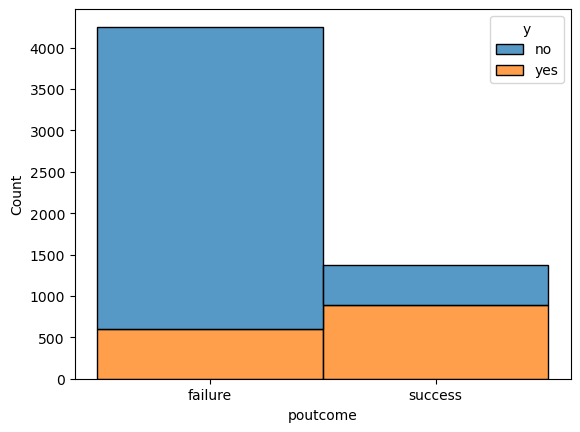

In [19]:
# Examine the success of campaigns with those customers who the bank had success before

bank_prevoutcome = bankdata[(bankdata['poutcome'] == 'success') | (bankdata['poutcome'] == 'failure')][['poutcome', 'y']]
bank_prevoutcome.head(3)

sns.histplot(data=bank_prevoutcome, x='poutcome', hue='y', multiple='stack')

returned_customers = len(bankdata[(bankdata.poutcome=='success') & (bankdata.y=='yes')])/len(bankdata[bankdata.poutcome=='success'])
print('Returned clients who has subscribed to the new term deposit: {}%'.format(round(returned_customers*100)))

<font color=darkred>The customers who had accepted a term deposit before, have a higher chance of accepting a new term deposit</font>

<Axes: xlabel='month', ylabel='count'>

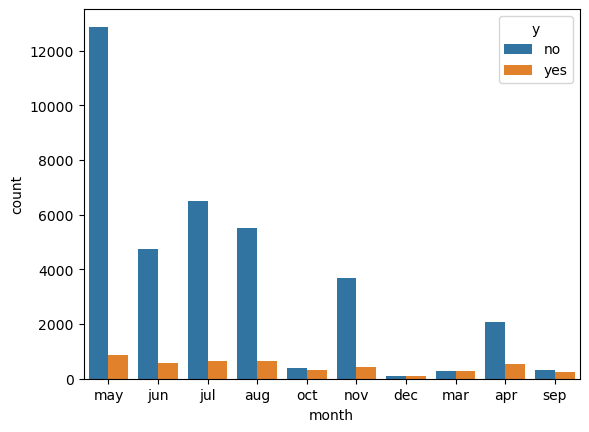

In [20]:
# compare the number of calls made across months, to see if the highest number of calls are made in months with high chance of success

sns.countplot(x='month', hue='y', data=bankdata)

<font color=darkred>
It is interesting to observe that the months with the highest sucess rates, have the least number of calls being made

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Objective
<font color=darkred>
Create a machine learning model that can help predict success rates for calls made during a marketing campaign. Determine which attributes of customer, campaign or social/economic attributes have the highest influence on the success

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

<font color=darkred>

- drop the duration feature
- change the education feature to an ordinal (in the pipeline)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [21]:
X = bankdata.drop(columns = ['y', 'y_numeric'])  
y = bankdata['y']

# categorical columns
X_encoded = pd.get_dummies(X)

scaler = StandardScaler()

# Scale only numerical columns
numerical_cols = X_encoded.select_dtypes(include=['int64', 'float64']).columns
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape)
y_train.value_counts()

(28823, 60) (12353, 60)


y
no     25618
yes     3205
Name: count, dtype: int64

In [22]:
# X = bankdata.drop(columns = ['y', 'y_numeric'])  
# y = bankdata['y']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# print(X_train.shape, X_test.shape)
# y_train.value_counts()

In [23]:
# Undersample for the minority class
undersampler = RandomUnderSampler(random_state=0)

# Apply the undersampler to the training data
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Check the new class distribution
print(f'Class distribution after undersampling:\n{y_train_undersampled.value_counts()}')

Class distribution after undersampling:
y
no     3205
yes    3205
Name: count, dtype: int64


In [24]:
# Oversample the minority class using SMOTE
smote = SMOTE(random_state=0)  

X_train_oversample, y_train_oversample = smote.fit_resample(X_train, y_train) 

# after oversampling the minority class
print(f'After balancing the target variable is: {y_train_oversample.value_counts()}')

After balancing the target variable is: y
no     25618
yes    25618
Name: count, dtype: int64


### Helper functions

In [25]:
# HELPER FUNCTIONS

#empty dataframe to store the results of all gridsearch modelevaluations
models_evaluated = pd.DataFrame()

# Fit the grid
def fit_grid(grid, X_train, y_train):
    start = time.time()
    grid.fit(X_train, y_train)
    end = time.time()
    fitTime = end - start
    return round(fitTime,2)

# Predict using the grid
def predict_grid(grid, X_test):
    start = time.time()
    y_pred = grid.predict(X_test)
    end = time.time()
    predictTime = end - start
    return y_pred, round(predictTime,2)

# Extract scores from the models, and print confusion matrix

def get_scores_and_displaycm(fitted_grid, model_prefix, y_test, y_pred, fitTime, predictTime):

    _classes = fitted_grid.best_estimator_.named_steps[model_prefix].classes_
    cm = confusion_matrix(y_test, y_pred, labels = _classes)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = _classes)
    # show the plot    
    plt.figure(figsize=(3, 3))
    disp.plot()
    plt.show()
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label='yes')
    precision = precision_score(y_test, y_pred, pos_label='yes')
    specificity = specificity_score(y_test, y_pred, pos_label='yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')
    
    print(classification_report(y_test, y_pred))

    pred = fitted_grid.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label='yes')
    grid_auc = auc(fpr, tpr)
    
    # find the grid fit time for the best model
    grid_fit_time_rank1_model = pd.DataFrame(fitted_grid.cv_results_).query('rank_test_score == 1').mean_fit_time.values[0]
    
    return {'model': model_prefix, 
            'test accuracy': round(accuracy,3),
            'precision': round(precision,3), 
            'recall': round(recall,3),
            'specificity': round(specificity,3),
            'f1': round(f1,3),
            'AUC': round(grid_auc,3),
            'grid total fit time': round(fitTime,3),
            'best model mean fit time': round(grid_fit_time_rank1_model,3),
            'grid predict time': round(predictTime,3),
            'best params': fitted_grid.best_params_
}

def fit_predict_evaluate(grid, model_name, X_train, y_train, X_test, y_test):    
    
    #fit the grid
    fitTime = fit_grid(grid, X_train, y_train)

    # make predictions
    y_pred, predictTime = predict_grid(grid, X_test)

    # show confusion matrix and other scores
    dict = get_scores_and_displaycm(grid, model_name, y_test, y_pred, fitTime, predictTime)

    # returns the results/scores of this evaluation
    return dict

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [26]:
from sklearn.dummy import DummyClassifier

In [27]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
print (dc.score(X_test, y_test))


0.883914838500769


### Problem 8: A Simple Model - Logistic Regression

Use Logistic Regression to build a basic model on your data.  

AUC: 0.7890830708565997


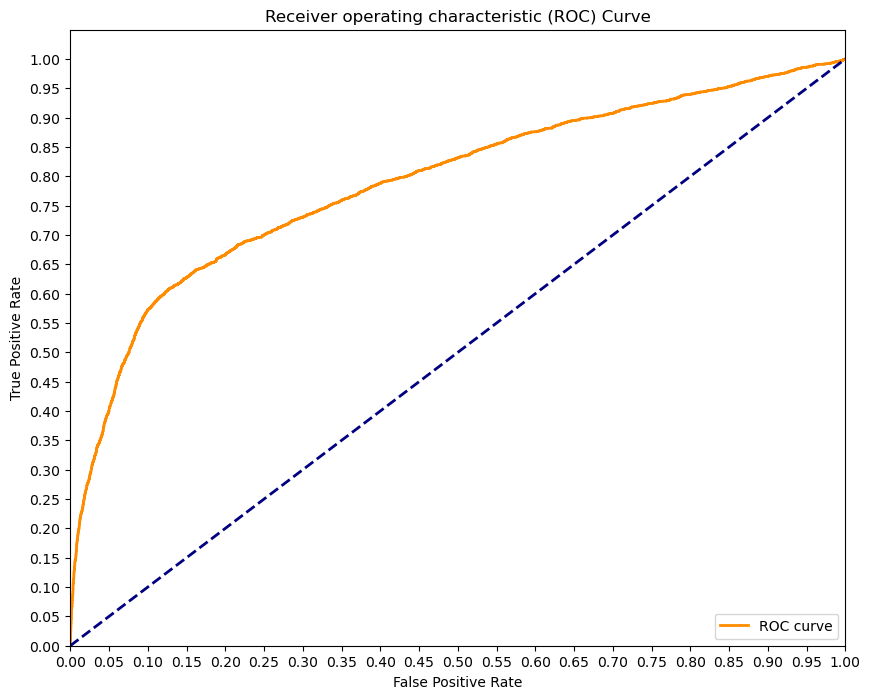

In [28]:
lr = LogisticRegression(fit_intercept=False, random_state=42, n_jobs=-1, max_iter=10000)
lr.fit(X_train, y_train)

y_score = lr.decision_function(X_train)
pred = lr.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_train, y_score, pos_label='yes')

grid_auc = auc(fpr, tpr)

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
# Evaluate Logistic Regression

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          no       0.91      0.99      0.94     10919
         yes       0.69      0.21      0.32      1434

    accuracy                           0.90     12353
   macro avg       0.80      0.60      0.63     12353
weighted avg       0.88      0.90      0.87     12353



<font color=darkred>Our main focus is to improve F1-score and recall metric. While a high precision is important, a higher recall is more important so we do not turn away customers who could have purchased bank's term deposits.

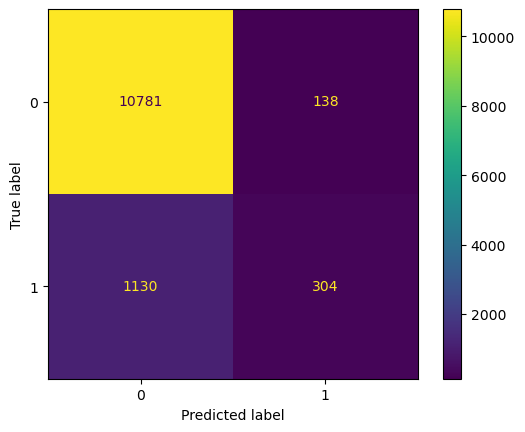

In [30]:
# print confusion matrix

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot()

In [31]:
#   get the feature names
feature_names = lr.feature_names_in_

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]

# get the coefficients
coefficients = lr.coef_[0]

# convert the coefficients to odds ratio
coefficients = np.exp(coefficients)

coefficients_df = pd.DataFrame({'feature': clean_feature_names, 'coefficient': coefficients})

coefficients_df.sort_values('coefficient', ascending=False).head(10)

,feature,coefficient
47,month_mar,3.355442
3,cons.price.idx,2.748474
59,poutcome_success,2.122189
5,euribor3m,1.765418
27,education_illiterate,1.523033
43,month_aug,1.270536
44,month_dec,1.259617
12,job_retired,1.199889
6,nr.employed,1.153019
15,job_student,1.134140


### Problem 9: Evaluate KNN, LR, SVM and DT with default parameters for balanced (under and oversample)

In [32]:
lr = LogisticRegression(fit_intercept=False, random_state=42, n_jobs=-1, max_iter=10000) 
svm = SVC()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()

classifiers = [lr, svm, dt, knn]
classifiers_names = ['Logistic Regression', 'SVM','Decision Tree', 'KNN']

#### Testing classifiers with default parameters and with balanced dataset (over sampled)

In [33]:
scores = []
for i in range(len(classifiers)):
    
    #fit the grid
    fitTime = fit_grid(classifiers[i], X_train_oversample, y_train_oversample)

    # make predictions
    y_pred, predictTime = predict_grid(classifiers[i], X_test)

    recall = recall_score(y_test, y_pred, pos_label='yes')
    precision = precision_score(y_test, y_pred, pos_label='yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')
    accuracy = accuracy_score(y_test, y_pred)

    classifier_metrics = {'Classifier': classifiers_names[i], 'accuracy': accuracy,
                          'F1-Score': f1, 'Precision': precision, 'Recall': recall, 
                          'Fit Time': fitTime}
    
    scores.append(classifier_metrics)
    
scores_df = pd.DataFrame(scores)
scores_df

,Classifier,accuracy,F1-Score,Precision,Recall,Fit Time
0,Logistic Regression,0.883186,0.475845,0.496588,0.456764,0.73
1,SVM,0.895086,0.409298,0.590789,0.313110,54.59
2,Decision Tree,0.838258,0.327273,0.316406,0.338912,0.32
3,KNN,0.847810,0.401274,0.369285,0.439331,0.05


#### Testing classifiers with balanced variables and with balanced dataset (under sampled)

In [34]:
scores = []
for i in range(len(classifiers)):

    #fit the grid
    fitTime = fit_grid(classifiers[i], X_train_undersampled, y_train_undersampled)

    # make predictions
    y_pred, predictTime = predict_grid(classifiers[i], X_test)

    recall = recall_score(y_test, y_pred, pos_label='yes')
    precision = precision_score(y_test, y_pred, pos_label='yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')
    accuracy = accuracy_score(y_test, y_pred)

    classifier_metrics = {'Classifier': classifiers_names[i], 'accuracy': accuracy,
                          'F1-Score': f1, 'Precision': precision, 'Recall': recall, 
                          'Fit Time': fitTime}
    
    scores.append(classifier_metrics)
    
scores_df = pd.DataFrame(scores)
scores_df

,Classifier,accuracy,F1-Score,Precision,Recall,Fit Time
0,Logistic Regression,0.824982,0.458959,0.357923,0.639470,0.73
1,SVM,0.844815,0.483149,0.393846,0.624826,1.72
2,Decision Tree,0.641626,0.303602,0.196019,0.672943,0.03
3,KNN,0.739820,0.375437,0.260237,0.673640,0.01


<font color=darkred>

#### Undersampling has bettter recall scores for all the models ~ 63% 

**Logistic Regression** and **SVM** best performance and are pretty close on F1-Score. I will explore these classifiers with GridSearchCV and vary on hyper parameters

### Problem 10: Logistic Regression Grid Search

In [35]:
params = {'lr__solver': ['lbfgs', 'liblinear'],
                   'lr__C': [0.0001, 0.0001, 0.001, 1.0]}

max_iterations = 10000

Fitting 5 folds for each of 8 candidates, totalling 40 fits


<Figure size 300x300 with 0 Axes>

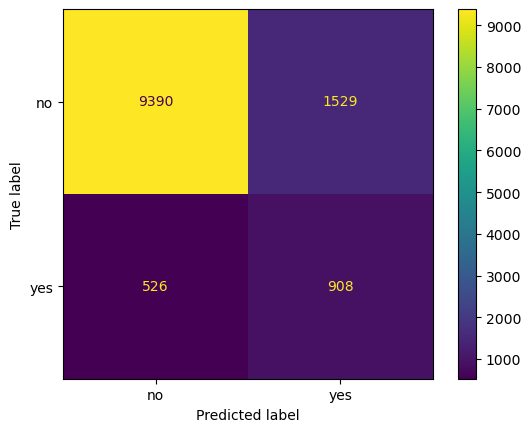

              precision    recall  f1-score   support

          no       0.95      0.86      0.90     10919
         yes       0.37      0.63      0.47      1434

    accuracy                           0.83     12353
   macro avg       0.66      0.75      0.69     12353
weighted avg       0.88      0.83      0.85     12353



,model,test accuracy,precision,recall,specificity,f1,AUC,grid total fit time,best model mean fit time,grid predict time,best params
0,lr,0.834,0.373,0.633,0.86,0.469,0.802,1.66,0.151,0.02,"{'lr__C': 1.0, 'lr__solver': 'liblinear'}"


In [36]:
# Logistic Regression model

lr_pipe = Pipeline([('scaler', StandardScaler()),('lr', LogisticRegression(fit_intercept=False, 
                                                                           random_state=42, 
                                                                           max_iter=max_iterations))])

#lr_grid = GridSearchCV(lr_pipe, params, cv=5, scoring='roc_auc', n_jobs=10, verbose=1)
lr_grid = GridSearchCV(lr_pipe, params, cv=5, n_jobs=10, verbose=1)


# fit and evaluate the model
dict = fit_predict_evaluate(lr_grid, 'lr', X_train_undersampled, y_train_undersampled, X_test, y_test)

models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)
models_evaluated


In [64]:
# get the feature names
feature_names = lr_grid.best_estimator_.feature_names_in_

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]
clean_feature_names[:5]


['age', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']

<font color=darkred>
Logistic regression provides Log Odds. Convert Log Odds to Odds Ratio and determin the top 10 coeefficients

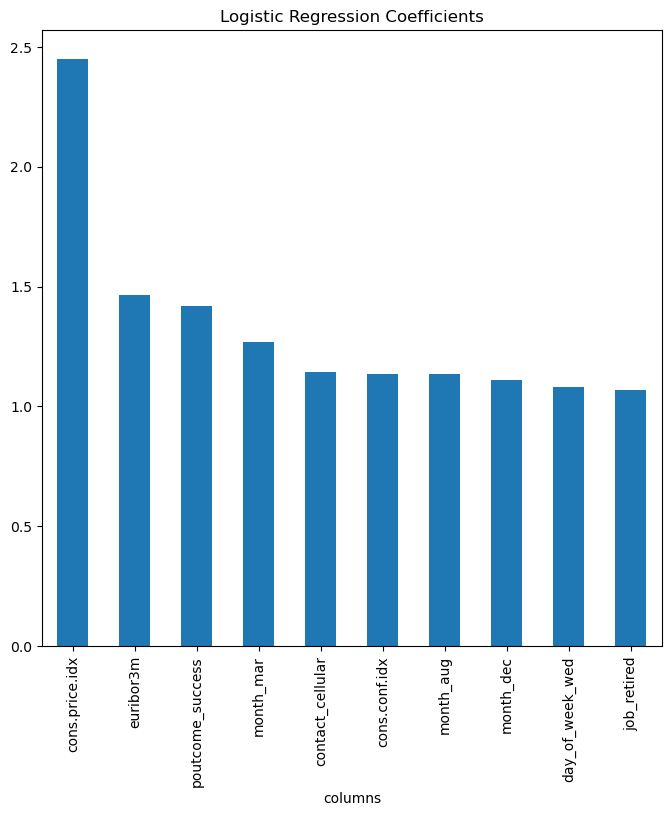

In [74]:
# get the coefficients
coefficients = lr_grid.best_estimator_.named_steps["lr"].coef_[0]

# convert the coefficients to odds ratio
coefficients = np.exp(coefficients)

# converting coefficients into df 
lr_results = pd.DataFrame({"columns": clean_feature_names, "values" : coefficients}).sort_values(by = "values", ascending = False)

# bar plot
lr_results.head(10).plot(kind='bar', x='columns', y='values', legend=False, figsize=(8, 8))

# Adding labels and title to the plot
plt.title('Logistic Regression Coefficients')

# Display the plot
plt.show()

<font color=darkred>

Odds of success increase:
- To customers who have an admin job, have a college degree, and calls made on wed, and Thu

In [76]:
lr_results.tail(10).sort_values(by= 'values', ascending = True)   

,columns,values
2,emp.var.rate,0.161815
33,default_yes,0.207390
57,poutcome_failure,0.814336
48,month_may,0.833432
41,contact_telephone,0.875525
58,poutcome_nonexistent,0.903654
46,month_jun,0.918223
49,month_nov,0.926321
53,day_of_week_mon,0.935875
23,education_basic.4y,0.958590


<font color=darkred>

It is surprising to note that the LR model does not considering the following features to be as important:
- nr.employed, emp.var.ratee, euribor3m rates - this is expected since these are socio economic indicators
- age : EDA suggested that customers greater than 65 had higher success with bank deposit offers


### 8 Decision Tree Model

In [79]:
# setup a GridSearchCV for the Decision Tree model

params = {'dt__min_impurity_decrease': [0.001, 0.01, 0.1],
         'dt__max_depth': [6,8,10],
         'dt__min_samples_split': [0.1, 0.05]}

#params = {'dt__max_depth': [2,4,6,8,10]}

# transformer = make_column_transformer(
#     (OneHotEncoder(drop='if_binary'), [col for col in categorical_columns if col != 'education']),
#     (OrdinalEncoder(categories=[['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'unknown']]), ['education'])
# )

dt_pipe = Pipeline([('dt', DecisionTreeClassifier(random_state = 42))])
#dt_grid = GridSearchCV(estimator=dt_pipe, param_grid=params, scoring='roc_auc', n_jobs=10, verbose=3)

dt_grid = GridSearchCV(estimator=dt_pipe, param_grid=params, n_jobs=10, verbose=2)

dt_grid

GridSearchCV(estimator=Pipeline(steps=[('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=10,
             param_grid={'dt__max_depth': [6, 8, 10],
                         'dt__min_impurity_decrease': [0.001, 0.01, 0.1],
                         'dt__min_samples_split': [0.1, 0.05]},
             verbose=2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.0s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.0s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.0s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.0s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total time=   0.0s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.0s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total time=   0.0s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total time=   0.0s
[CV] END dt__max_depth=6, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total tim

<Figure size 300x300 with 0 Axes>

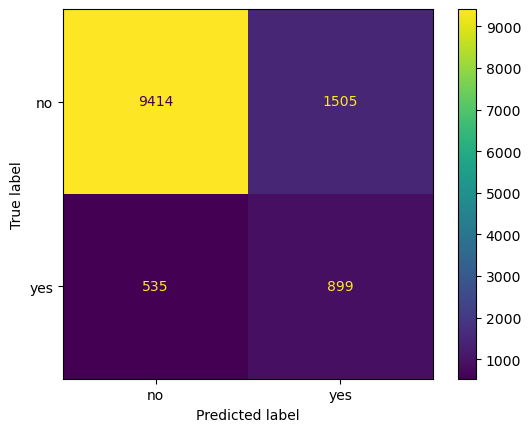

              precision    recall  f1-score   support

          no       0.95      0.86      0.90     10919
         yes       0.37      0.63      0.47      1434

    accuracy                           0.83     12353
   macro avg       0.66      0.74      0.69     12353
weighted avg       0.88      0.83      0.85     12353



,model,test accuracy,precision,recall,specificity,f1,AUC,grid total fit time,best model mean fit time,grid predict time,best params
0,lr,0.834,0.373,0.633,0.860,0.469,0.802,1.66,0.151,0.02,"{'lr__C': 1.0, 'lr__solver': 'liblinear'}"
1,dt,0.836,0.373,0.604,0.866,0.461,0.750,0.77,0.019,0.01,{'dt__max_depth': 2}
2,svm,0.837,0.375,0.614,0.866,0.466,0.776,140.66,58.931,0.91,{'svm__kernel': 'linear'}
3,dt,0.835,0.374,0.627,0.862,0.468,0.794,6.50,0.032,0.00,"{'dt__max_depth': 6, 'dt__min_impurity_decreas..."
4,dt,0.835,0.374,0.627,0.862,0.468,0.794,0.57,0.027,0.00,"{'dt__max_depth': 6, 'dt__min_impurity_decreas..."


In [80]:
# fit the model and evaluate the model
dict = fit_predict_evaluate(dt_grid, 'dt', X_train_undersampled, y_train_undersampled, X_test, y_test)

models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)
models_evaluated

In [81]:
# export the tree

feature_names = dt_grid.best_estimator_.feature_names_in_

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]
print(clean_feature_names)

dt = dt_grid.best_estimator_.named_steps['dt']

depth = export_text(dt, feature_names=clean_feature_names)
export_text(dt, feature_names=clean_feature_names, show_weights=True)

print(depth)

['age', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure'

In [82]:
# check for the importance of features

features_importance = pd.DataFrame({'feature': clean_feature_names, 'importance': dt.feature_importances_})
    
features_importance.sort_values(by='importance', ascending=False).head(10)

,feature,importance
6,nr.employed,0.722256
4,cons.conf.idx,0.160122
5,euribor3m,0.062329
50,month_oct,0.024472
59,poutcome_success,0.022567
3,cons.price.idx,0.008254
39,loan_yes,0.000000
43,month_aug,0.000000
42,month_apr,0.000000
41,contact_telephone,0.000000


<font color=darkred>

The Decision tree model gives the most importance to 
- number of people employed in the bank at the root node
- consumer confidence index
- and Euribor3m rates

This is in  conflict with the feature importance from LogisticRegression model, specially for the number of people employed



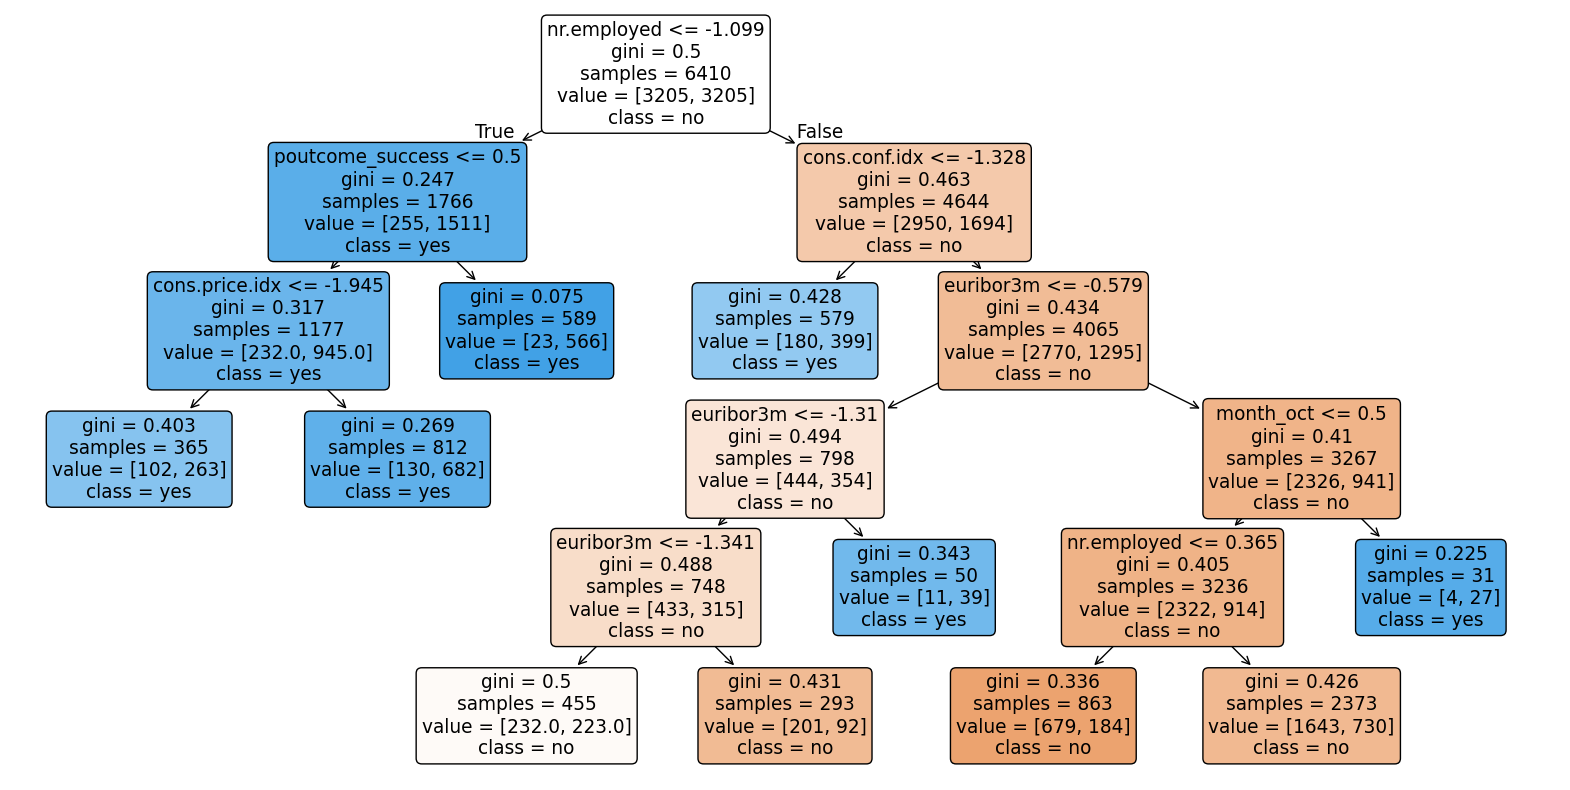

In [83]:
from sklearn.tree import plot_tree

# Get the best decision tree model
dt = dt_grid.best_estimator_.named_steps['dt']

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=clean_feature_names, class_names=dt.classes_, filled=True, rounded=True)
plt.show()

### 8 SVM

In [84]:
# setup a GridSearchCV for the SVM model

# params = {'svm__kernel': ['rbf', 'poly', 'linear'],
#          'svm__gamma': [0.1, 1.0],}

params = {'svm__kernel': ['linear', 'sigmoid', 'rbf', 'poly'],}

svm_pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC(random_state = 42, probability=True))])

svm_grid = GridSearchCV(estimator=svm_pipe, param_grid=params, scoring='roc_auc', n_jobs=10, verbose=4)

svm_grid

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=10,
             param_grid={'svm__kernel': ['linear', 'sigmoid', 'rbf', 'poly']},
             scoring='roc_auc', verbose=4)

In [85]:
# fit the model and evaluate the model

# fit the model and evaluate the model
dict = fit_predict_evaluate(svm_grid, 'svm', X_train_undersampled, y_train_undersampled, X_test, y_test)

models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)
models_evaluated

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 5/5] END ...............svm__kernel=sigmoid;, score=0.704 total time=  11.2s
[CV 1/5] END ...............svm__kernel=sigmoid;, score=0.715 total time=  11.7s
[CV 4/5] END ...............svm__kernel=sigmoid;, score=0.728 total time=  11.7s
[CV 2/5] END ...............svm__kernel=sigmoid;, score=0.736 total time=  11.7s
[CV 3/5] END ...............svm__kernel=sigmoid;, score=0.718 total time=  11.7s
[CV 1/5] END ...................svm__kernel=rbf;, score=0.768 total time=   8.3s
[CV 5/5] END ...................svm__kernel=rbf;, score=0.751 total time=   8.0s
[CV 4/5] END ...................svm__kernel=rbf;, score=0.772 total time=   8.1s
[CV 2/5] END ...................svm__kernel=rbf;, score=0.768 total time=   8.3s
[CV 3/5] END ...................svm__kernel=rbf;, score=0.778 total time=   8.3s
[CV 1/5] END ..................svm__kernel=poly;, score=0.765 total time=   7.8s
[CV 3/5] END ..................svm__kernel=poly;,

: 

: 

In [72]:
# get the feature names
#feature_names = lr_grid.best_estimator_.named_steps['scaler'].get_feature_names_out()
feature_names = svm_grid.best_estimator_.feature_names_in_

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]
clean_feature_names[:5]

features_importance = svm_grid.best_estimator_.named_steps['svm'].coef_

pd.DataFrame({'feature': clean_feature_names, 'importance': features_importance[0]}).sort_values(by='importance', ascending=False).head(10)

,feature,importance
5,euribor3m,1.705286
3,cons.price.idx,0.810581
42,month_apr,0.290214
43,month_aug,0.261719
47,month_mar,0.222183
59,poutcome_success,0.097869
45,month_jul,0.082036
4,cons.conf.idx,0.069763
22,marital_unknown,0.001762
40,contact_cellular,0.001619


### Problem 9: Score the Model

What is the accuracy of your model?

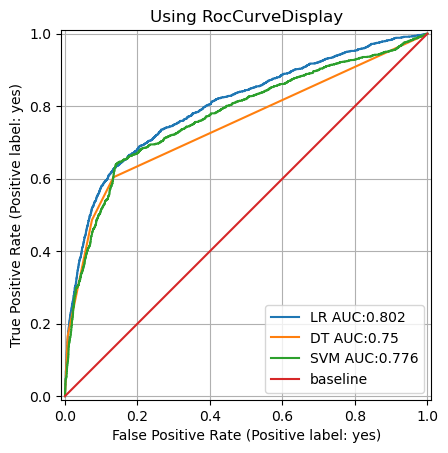

In [47]:
# create ROC curve for all the models

fig, ax = plt.subplots()

lr_label = 'LR AUC:' + str(models_evaluated[models_evaluated['model'] == 'lr']['AUC'].values[0])
#knn_label = 'KNN AUC:' + str(models_evaluated[models_evaluated['model'] == 'knn']['AUC'].values[0])
dt_label = 'DT AUC:' + str(models_evaluated[models_evaluated['model'] == 'dt']['AUC'].values[0])
svm_label = 'SVM AUC:' + str(models_evaluated[models_evaluated['model'] == 'svm']['AUC'].values[0])

#RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = knn_label)
RocCurveDisplay.from_estimator(lr_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = lr_label)
RocCurveDisplay.from_estimator(dt_grid, X_test, y_test, pos_label = 'yes', ax = ax, label =  dt_label    )
RocCurveDisplay.from_estimator(svm_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = svm_label) 
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions